In [1]:
import scipy.stats
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr
import tqdm
import os
import pickle

## set plotting style
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## initialize random number generator
rng = np.random.default_rng()

## Functions

In [2]:
def fit_model(data, model_class):
    """Get model fitted to data. Returns scipy.rv_continuous object"""

    ## First, estimate parameters
    bounds = dict(c=[-1e1, 1e1], loc=[300, 350], scale=[1e-1, 1e1])
    params = scipy.stats.fit(dist=model_class, data=data, bounds=bounds).params

    ## instantiate random variable
    rv = model_class(*params)

    return rv


def get_return_levels(rv, return_periods=np.logspace(0.01, 3.5)):
    """get return value for given random variable at given return times"""

    return rv.isf(1 / return_periods), return_periods


def draw_sample(data, n=None):
    """draw random (bootstrap) sample from data.
    'n' is number of elements in given sample"""

    if n is None:
        n = len(data)

    return rng.choice(data, size=n, replace=True)


def load_return_period_bnds(data, model_class, save_fp, n_samples=1000, alpha=0.05):
    """load in or compute return period bounds"""

    if os.path.isfile(save_fp):

        ## open saved data
        with open(save_fp, "rb") as file:
            bounds = pickle.load(file)

        lb = bounds["lb"]
        ub = bounds["ub"]

    else:

        ## compute bounds
        lb, ub = compute_return_period_bnds(
            data, model_class=model_class, n_samples=n_samples, alpha=alpha
        )

        ## save to file
        with open(save_fp, "wb") as file:
            pickle.dump({"lb": lb, "ub": ub}, file)

    return lb, ub


def compute_return_period_bnds(data, model_class, n_samples=1000, alpha=0.05):
    """get bounds for return period using bootstrap sampling"""

    ## empty list to hold result
    return_levels_samples = []

    ## loop through number of samples
    for _ in tqdm.tqdm(range(n_samples)):

        ## fit model on bootstrapped sample
        model = fit_model(draw_sample(data), model_class=model_class)

        ## compute return period
        return_levels_samples.append(get_return_levels(model)[0])

    ## convert to array and compute bounds
    return_levels_samples = np.stack(return_levels_samples, axis=0)
    lb, ub = np.quantile(return_levels_samples, axis=0, q=[alpha / 2, 1 - alpha / 2])

    return lb, ub


def load_data():
    """Load raw data from CSV file"""

    # Load from CSV
    data = pd.read_csv("../data/train/A_tas_lat.41_lon.272_spatial.2_reduce.max.csv")

    # set time data as index
    data = data.set_index("time")

    # convert to xarray
    data = xr.Dataset.from_dataframe(data)["tas"]

    # update time axis (string to cftime object)
    updated_time = xr.cftime_range(
        start=data["time"].values[0], periods=len(data["time"]), freq="1D"
    )
    data["time"] = updated_time

    return data


def load_prepped_data(model_type, thresh=None):
    """
    Load prepped data. Pre-processing depends on model type:
        - if model_type=='gev' block the data
        - if model_type=='gp', get peaks over threshold
    """

    ## load raw data
    data = load_data()

    if model_type == "gev":
        data_prepped = data.groupby("time.year").max().values

    elif model_type == "gp":
        data_prepped = data.isel(time=data > thresh).values

    else:
        print("Error: input valid model class")
        return

    return data_prepped


def get_train_test_split(data_prepped, n_train):
    """Get train-test split between training data.
    Defaults to randomly selecting training data"""

    ## To-do

    return


def get_empirical_pdf(data, bin_edges=None):
    """function to get empirical PDF (normalized histogram)"""

    ## Set bin_edges if unspecified
    if bin_edges is None:
        bin_edges = np.linspace(np.floor(data.min()), np.ceil(data.max()), 20)

    ## make histogram
    counts, _ = np.histogram(X, bins=bin_edges)

    # normalize histogram
    bin_width = bin_edges[1:] - bin_edges[:-1]
    pdf_empirical = counts / (counts * bin_width).sum()

    return pdf_empirical, bin_edges


def get_empirical_return_period(X):
    """Get empirical return period. Returns 'tr_empirical' and 'Xr_empirical';
    both are used to plot empirical return period."""

    # Empirical return period
    Xr_empirical = np.sort(X)
    n = len(X)
    m = np.arange(1, n + 1)
    cdf_empirical = m / (n + 1)
    tr_empirical = 1 / (1 - cdf_empirical)

    return tr_empirical, Xr_empirical

In [3]:
## specify model type, one of {"gev", "gp"}
model_type = "gev"

if model_type == "gev":
    model_class = scipy.stats.genextreme
    thresh = None

elif model_type == "gp":
    model_class = scipy.stats.genpareto
    thresh = 318

## Load data
X = load_prepped_data(model_type=model_type, thresh=thresh)

## Empirical PDF (normalized histogram)
pdf_empirical, bin_edges = get_empirical_pdf(X)

## Empirical return period
tr_empirical, Xr_empirical = get_empirical_return_period(X)

## Fit model and get return levels
model = fit_model(X, model_class)
Xr, tr = get_return_levels(model)

## Compute confidence interval
bounds_fp = f"../data/{model_type}_bounds.pkl"
Xr_lb, Xr_ub = load_return_period_bnds(
    X, model_class=model_class, n_samples=1000, save_fp=bounds_fp
)

## Plot PDF

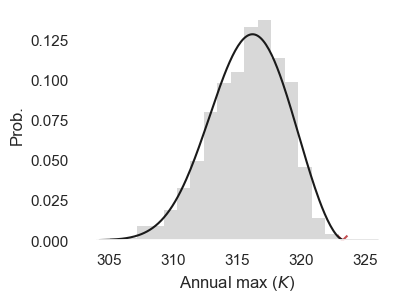

In [4]:
## test points to plot curve
X_test = np.linspace(X.min(), 326, 200)

## setup plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot empirical pdf
ax.stairs(pdf_empirical, edges=bin_edges, color="gray", fill=True, alpha=0.3)

## plot distribution fit
ax.plot(X_test, model.pdf(X_test), c="k")

## plot max value
ax.scatter(X.max(), 0, marker="x", c="r", s=50)

## label
ax.set_xlabel(r"Annual max ($K$)")
ax.set_ylabel("Prob.")

plt.show()

## Plot return level

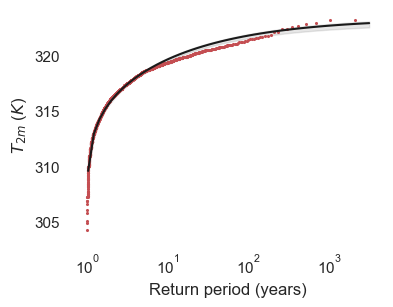

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))

## plot modeled return period
ax.plot(tr, Xr, c="k")
ax.fill_between(tr, Xr_ub, Xr_lb, color="k", alpha=0.1)

## plot empirical return period
ax.scatter(tr_empirical, Xr_empirical, c="r", s=1.5)

## label axes
ax.set_xlabel("Return period (years)")
ax.set_ylabel(r"$T_{2m}$ ($K$)")
ax.set_xscale("log")

plt.show()